<h2>Kaggle Challenge : Predict Future Sales - Notebook</h2>
link : https://www.kaggle.com/c/competitive-data-science-predict-future-sales

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import uniform, randint
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt

<h4>Common methods used for models evaluation / hyperparameters otpimisation</h4>
This method takes the result of the RandomizedSearch/GridSearch and report the scores of the 'n' first best models, with the according parameters.

In [2]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

<h4>Initializing dataframes</h4>


In [272]:
# Data repositories
data_folder = "data"
results_folder = "results"

if not os.path.exists(data_folder):
    os.makedirs(data_folder)
    
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# Filenames
shops_filename = "shops.csv"
items_filename = "items.csv"
item_categories_filename = "item_categories.csv"
train_filename = "sales_train.csv.gz"
eval_filname = "test.csv.gz"

In [273]:
# Reading files
shops = pd.read_csv(data_folder+"/"+shops_filename)
items = pd.read_csv(data_folder+"/"+items_filename)
item_categories = pd.read_csv(data_folder+"/"+item_categories_filename)
train = pd.read_csv(data_folder+"/"+train_filename, compression='gzip')
eval_df = pd.read_csv(data_folder+"/"+eval_filname, compression='gzip')

In [274]:
# Shops dataframe - formatted : city_name shop_name 
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['city'] = LabelEncoder().fit_transform(shops['city'])

In [275]:
# Item categories datagrame - formatted : category - sub_category
item_categories['category_type'] = item_categories['item_category_name'].str.split('-').map(lambda x: x[0])
item_categories['category_type'] = LabelEncoder().fit_transform(item_categories['category_type'])

In [276]:
# Dropping outliers
train = train[(train['item_price'] < 50000) & (train['item_price'] > 0)]
train = train[train.item_cnt_day<500]

In [277]:
# Fixing dataframes shop_ids
train.loc[train['shop_id'] == 0, 'shop_id'] = 56
train.loc[train['shop_id'] == 10, 'shop_id'] = 11
train.loc[train['shop_id'] == 1, 'shop_id'] = 58

eval_df.loc[eval_df['shop_id'] == 0, 'shop_id'] = 56
eval_df.loc[eval_df['shop_id'] == 10, 'shop_id'] = 11
eval_df.loc[eval_df['shop_id'] == 1, 'shop_id'] = 58

<h2>Monthly prediction</h2>
<h5>In this first method I will aggregate the sales of every product on a month basis and predict the number of items sold per shop, per month</h5>
<h3>Preprocessing of the train / test dataset</h3>
<h4>Training dataset</h4>
Shape : [date, date_block_num, shop_id, item_id, item_price, item_cnt_day]

In [311]:
# Aggregation of the price for each item group by shop item and date_block_num
train_monthly_grouped = train.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False).agg({'item_price': 'median', 'item_cnt_day': 'count'})

In [312]:
# add rows with null item counts
matrix = []
for i in range(34):
    sales = train_monthly_grouped[train_monthly_grouped['date_block_num'] == i]
    sales = pd.merge(sales, eval_df[['item_id','shop_id']], on=['item_id','shop_id'], how='outer')
    sales['item_cnt_day'] = sales['item_cnt_day'].fillna(0)
    sales['date_block_num'] = i
    matrix.append(sales)
    
train_monthly_grouped = pd.DataFrame(np.vstack(matrix), columns = ['date_block_num','shop_id', 'item_id', 'item_price', 'item_cnt_day'])
print(train_monthly_grouped.count())

date_block_num    8288770
shop_id           8288770
item_id           8288770
item_price        1607380
item_cnt_day      8288770
dtype: int64


In [313]:
# Fill the 'item_price' column
train_monthly_grouped['item_price'] = train_monthly_grouped.groupby(['shop_id','item_id'])['item_price'].transform(lambda x: x.fillna(x.median()))
train_monthly_grouped['item_price'] = train_monthly_grouped.groupby('item_id')['item_price'].transform(lambda x: x.fillna(x.median()))
train_monthly_grouped['item_price'] = train_monthly_grouped['item_price'].fillna(train_monthly_grouped['item_price'].median())

C:\Users\cbouyssi\AppData\Local\Continuum\anaconda3\envs\powercaster-imp\lib\site-packages\numpy\lib\nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\cbouyssi\AppData\Local\Continuum\anaconda3\envs\powercaster-imp\lib\site-packages\numpy\lib\nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


date_block_num    8288770
shop_id           8288770
item_id           8288770
item_price        8288770
item_cnt_day      8288770
dtype: int64


In [314]:
# Take the modulo of the month number to have seasonnality
train_monthly_grouped['month'] = train_monthly_grouped['date_block_num'].apply(lambda x : x % 12)
# Add feature "city"
train_monthly_grouped = pd.merge(train_monthly_grouped, shops[['shop_id','city']], on = ['shop_id'], how = 'left' )
# Add feature "item_category_id"
train_monthly_grouped = pd.merge(train_monthly_grouped, items[['item_id', 'item_category_id']], on = ['item_id'], how = 'left' )
# Add feature "category_type"
train_monthly_grouped = pd.merge(train_monthly_grouped, item_categories[['item_category_id', 'category_type']], on = ['item_category_id'], how = 'left' )

In [ ]:
# Add feature "last_month_cnt_item"
train_monthly_grouped['cnt_item_lag_1'] = train_monthly_grouped.groupby(['shop_id','item_id'])['item_cnt_day'].shift().fillna(0)
train_monthly_grouped['cnt_item_lag_2'] = train_monthly_grouped.groupby(['shop_id','item_id'])['item_cnt_day'].shift(2).fillna(0)
train_monthly_grouped.loc[train_monthly_grouped['date_block_num']<=0.0, ['cnt_item_lag_1']]= None
train_monthly_grouped.loc[train_monthly_grouped['date_block_num']<=1.0, ['cnt_item_lag_2']]= None
train_monthly_grouped[train_monthly_grouped['date_block_num'] <= 0.0]['cnt_item_lag_1'] = train_monthly_grouped.groupby(['shop_id','item_id'])['cnt_item_lag_1'].transform(lambda x: x.fillna(x.median()))
train_monthly_grouped[train_monthly_grouped['date_block_num'] <= 0.0]['cnt_item_lag_1'] = train_monthly_grouped.groupby(['item_id'])['cnt_item_lag_1'].transform(lambda x: x.fillna(x.median()))
train_monthly_grouped[train_monthly_grouped['date_block_num'] <= 1.0]['cnt_item_lag_2'] = train_monthly_grouped.groupby(['shop_id','item_id'])['cnt_item_lag_2'].transform(lambda x: x.fillna(x.median()))
train_monthly_grouped[train_monthly_grouped['date_block_num'] <= 1.0]['cnt_item_lag_2'] = train_monthly_grouped.groupby(['item_id'])['cnt_item_lag_2'].transform(lambda x: x.fillna(x.median()))
train_monthly_grouped['cnt_item_lag_1'] = train_monthly_grouped['cnt_item_lag_1'].fillna(0)
train_monthly_grouped['cnt_item_lag_2'] = train_monthly_grouped['cnt_item_lag_2'].fillna(0)

C:\Users\cbouyssi\AppData\Local\Continuum\anaconda3\envs\powercaster-imp\lib\site-packages\numpy\lib\nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [345]:
# Features
X = train_monthly_grouped.loc[:, train_monthly_grouped.columns != 'item_cnt_day']
# Target
Y = train_monthly_grouped['item_cnt_day'].rename({'item_cnt_day':'item_cnt_month'})

<h4>Testing dataset</h4>
Shape : [shop_id, item_id]
We'll have to associate the price of each item and add a column for the date_block_num (which will be the month number of the predictions : 34

In [336]:
# Create a ["shop_id", "item_id", "item_price"] dataframe to join with test dataset
prices = train[['shop_id', 'item_id', 'item_price']].drop_duplicates()
prices = prices.groupby(['shop_id', 'item_id'], as_index=False).agg({'item_price':'median'})

In [337]:
# Add prices 
eval_df_with_prices = pd.merge(eval_df, prices, on=['shop_id', 'item_id'], how = 'left')

For the ('shop_id', 'item_id') that weren't in the training dataset, we calculate the average price for each 'item_id'

In [338]:
eval_df_with_prices['item_price'] = eval_df_with_prices.groupby('item_id')['item_price'].transform(lambda x: x.fillna(x.median()))

C:\Users\cbouyssi\AppData\Local\Continuum\anaconda3\envs\powercaster-imp\lib\site-packages\numpy\lib\nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


For the remaining rows without 'item_price', we can't use anything besides : Median prices of all items OR median prices of all items of the same category.
<h4>--><h/4> Method 1 : Median price

In [339]:
eval_df_with_prices['item_price'] = eval_df_with_prices['item_price'].fillna(eval_df_with_prices['item_price'].median())

In [340]:
# Add feature "month number"
eval_df_with_prices['date_block_num'] = 34
# Add "month"
eval_df_with_prices['month'] = 34%12
# Add feature "city"
eval_df_with_prices = pd.merge(eval_df_with_prices, shops[['shop_id','city']], on = ['shop_id'], how = 'left' )
# Add feature "item_category_id"
eval_df_with_prices = pd.merge(eval_df_with_prices, items[['item_id', 'item_category_id']], on = ['item_id'], how = 'left' )
# Add feature "category_type"
eval_df_with_prices = pd.merge(eval_df_with_prices, item_categories[['item_category_id', 'category_type']], on = ['item_category_id'], how = 'left' )
# Add feature 'cnt_item_lag_1', 'cnt_item_lag_1'
eval_df_with_prices = pd.merge(eval_df_with_prices, X[X['date_block_num'] == 33][['shop_id','item_id','cnt_item_lag_1']], on=['shop_id','item_id'], how='left')
eval_df_with_prices = pd.merge(eval_df_with_prices, X[X['date_block_num'] == 32][['shop_id','item_id','cnt_item_lag_2']], on=['shop_id','item_id'], how='left')

<h3>Model Optimization /  Validation</h3>

In [253]:
# Splitting training df into 'train' and 'test' df
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=0)

In [254]:
xgb_model = xgb.XGBRegressor()

# Hyper parameters tunning
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=100, cv=2, verbose=1, n_jobs=-1, return_train_score=True)

search.fit(X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 107.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 448.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 468.8min finished
C:\Users\cbouyssi\AppData\Local\Continuum\anaconda3\envs\powercaster-imp\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:47:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:47:16] WARNING: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000146AD9DA0>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000146AD94A8>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000146AD9C18>, 'max_...146AD90B8>, 'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000000159345F8>}

In [259]:
report_best_scores(search.cv_results_)

Model with rank: 1
Mean validation score: 0.533 (std: 0.001)
Parameters: {'colsample_bytree': 0.8045997961875188, 'gamma': 0.04808827554571038, 'learning_rate': 0.31215697934688114, 'max_depth': 5, 'n_estimators': 138, 'subsample': 0.9746919954946938}

Model with rank: 2
Mean validation score: 0.529 (std: 0.000)
Parameters: {'colsample_bytree': 0.7467983561008608, 'gamma': 0.02904180608409973, 'learning_rate': 0.28985284373248055, 'max_depth': 5, 'n_estimators': 139, 'subsample': 0.8832290311184181}

Model with rank: 3
Mean validation score: 0.528 (std: 0.000)
Parameters: {'colsample_bytree': 0.8935310086091695, 'gamma': 0.3344620298315498, 'learning_rate': 0.28925026952157096, 'max_depth': 5, 'n_estimators': 147, 'subsample': 0.7123089449763423}



<h3>Evaluation</h3>
We can now pick the model with the best results from the list given by 'report_best_scores', train it with the entire training data and make the predictions for the submission.

In [355]:
xgb_model = xgb.XGBRegressor(colsample_bytree=0.8045997961875188, gamma=0.04808827554571038, learning_rate=0.31215697934688114, max_depth=5, n_estimators=138, subsample=0.9746919954946938)
xgb_model.fit(X,Y, eval_metric='rmse',eval_set=[(X,Y)], early_stopping_rounds=3)

[15:10:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:10:24] WARNING: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.01322
Will train until validation_0-rmse hasn't improved in 3 rounds.
[1]	validation_0-rmse:0.914165
[2]	validation_0-rmse:0.863334
[3]	validation_0-rmse:0.850475
[4]	validation_0-rmse:0.831307
[5]	validation_0-rmse:0.821044
[6]	validation_0-rmse:0.816752
[7]	validation_0-rmse:0.813411
[8]	validation_0-rmse:0.811521
[9]	validation_0-rmse:0.809443
[10]	validation_0-rmse:0.807103
[11]	validation_0-rmse:0.805691
[12]	validation_0-rmse:0.804347
[13]	validation_0-rmse:0.803394
[14]	validation_0-rmse:0.802703
[15]	validation_0-rmse:0.801643
[16]	validation_0-rm

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8045997961875188,
       gamma=0.04808827554571038, importance_type='gain',
       learning_rate=0.31215697934688114, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=138, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=0.9746919954946938, verbosity=1)

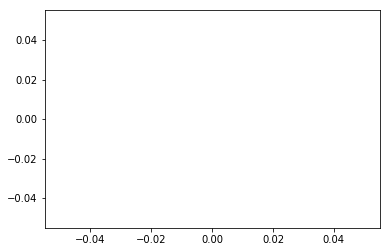

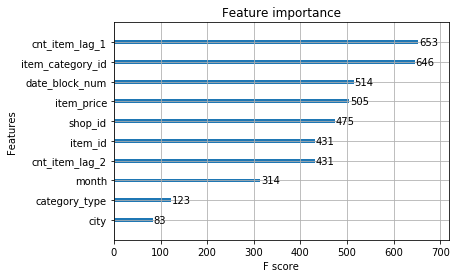

In [356]:
fig = plt.plot()
plot_importance(xgb_model)

In [357]:
# Make the predictions - The columns must be in the same order than the one used for training
predictions = xgb_model.predict(eval_df_with_prices[['date_block_num', 'shop_id', 'item_id', 'item_price', 'month', 'city', 'item_category_id', 'category_type','cnt_item_lag_1','cnt_item_lag_2']])
print(predictions)

[0.5003818  0.01723129 1.1920476  ... 0.13567257 0.07256615 0.14114353]


In [358]:
pd.DataFrame(predictions).to_csv(results_folder+"/"+"results")